<a href="https://colab.research.google.com/github/makrez/BioinformaticsTools/blob/master/autoencoders_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read data

In [244]:
import re
import os
!pip install biopython
from Bio import SeqIO
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [245]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        # Fill missing channels with zeros
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded



In [ ]:
flatted_sequence = list()
sequence_labels = list()

alignment_length = 1500

with open('drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
  for record in SeqIO.parse(handle, 'fasta'):
    label = str(record.description).rsplit(';', 1)[-1]
    seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
    
    if len(seq_hot) == alignment_length:
      flatted_sequence.append(seq_hot)
      sequence_labels.append(label)

In [248]:
from Bio import AlignIO
from collections import Counter

def summarize_msa(file_path, num_lines_to_display=5):
    alignment = AlignIO.read(file_path, 'fasta')
    num_sequences = len(alignment)
    alignment_length = alignment.get_alignment_length()

    # Count occurrences of each base and gaps
    counts = Counter()
    total_bases = num_sequences * alignment_length
    for record in alignment:
        counts.update(record.seq)
        
    # Calculate the percentages
    percentages = {base: (count / total_bases) * 100 for base, count in counts.items()}

    print(f"Number of sequences: {num_sequences}")
    print(f"Alignment length: {alignment_length}")
    print("\nPercentages of bases and gaps:")
    for base, percentage in percentages.items():
        if percentage > 0:
            print(f"{base}: {percentage:.2f}%")
    
    print("\nFirst few lines of the alignment:")
    for idx, record in enumerate(alignment):
        if idx < num_lines_to_display:
            print(f"{record.id}: {record.seq}")
        else:
            break

# Read and summarize the MSA
msa_file_path = 'drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln'
summarize_msa(msa_file_path)



Number of sequences: 2626
Alignment length: 4559

Percentages of bases and gaps:
-: 35.89%
c: 14.05%
g: 19.88%
u: 12.92%
a: 17.25%
y: 0.00%
n: 0.00%
r: 0.00%
v: 0.00%
w: 0.00%
m: 0.00%
s: 0.00%
k: 0.00%

First few lines of the alignment:
CP013727.2895443.2898376: ---------------------------cgguuaaguua-ga-aagggcg--cacgguggaug-ccuuggca-cuaggagccg--aug-a-----aggacggg-acgaacac-cgauaug-c-uuc-ggggagcuguaagcaagc-uuugaucc--ggag-auuuccgaau-ggggaaacccacca-cucguaauggagu---gguauccau--a-ucugaaua--cauaggauaugagaaggcagaccc-ggggaacug-aaacaucu-aagu-accc-gg-aggaagag-aaagcaaaugcga---uucccu-gaguag-cggcgag--cg-aaacggga-ccagcccaaa-ccaagagg---cuugccucuu-ggg-g-uuguagg-acacucu-guacggag-uuacaa-aggaacg-aggua---gaugaagaggucuggaaa-ggcccgccauag---gaggu-aacag-cccugua-gucaaaac----uucgu--ucu---cuccugagugg-auccuga-------------------------------------------------------------------------------------------------------------------------------guacggcgga------acacgug--aaauuccguc-ggaauc-cgggaggacc-aucucc-caaggc-uaaau----acucc

In [259]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the autoencoder
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()

#         # Encoding layers
#         self.encoder = nn.Sequential(
#             nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(2, stride=2),
#             nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool1d(2, stride=2)
#         )

#         # Decoding layers
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose1d(16, 6, kernel_size=3, stride=2, padding=0, output_padding=1), #, output_padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class ConvAutoencoder(nn.Module):
    def __init__(self, input_length):
        super(ConvAutoencoder, self).__init__()
        self.input_length = input_length
        
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        # Decoding layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 6, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Calculate padding sizes
        encoder_padding = (input_length - 1) % 2
        decoder_padding = (input_length % 2) * 2

        # Initialize padding layers
        self.pad_encoder = nn.ConstantPad1d((encoder_padding, 0), 0)
        self.pad_decoder = nn.ConstantPad1d((0, decoder_padding), 0)

        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        # Encoding layers
        x = self.pad_encoder(x)
        x = self.encoder(x)

        # Decoding layers
        x = self.decoder(x)
        x = self.pad_decoder(x)

        return x



# Instantiate the model
model = ConvAutoencoder(input_length = alignment_length)
print(model)


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
  (pad_encoder): ConstantPad1d(padding=(1, 0), value=0)
  (pad_decoder): ConstantPad1d(padding=(0, 0), value=0)
)


## Loading DNA data and transforming it to one-hot encoded data



In [260]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __getitem__(self, index):
        return torch.tensor(self.sequences[index]).float()
    
    def __len__(self):
        return len(self.sequences)


In [261]:
from torch.utils.data import DataLoader

# Create dataset
dataset = SequenceDataset(flatted_sequence)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [262]:
dataset = SequenceDataset(flatted_sequence)
print("Length of dataset:", len(dataset))

sample = dataset[0]
print("Shape of sample:", sample.shape)
#print(dataset[0])
print(model)

Length of dataset: 2626
Shape of sample: torch.Size([1500, 6])
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(8, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 6, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (3): Sigmoid()
  )
  (pad_encoder): ConstantPad1d(padding=(1, 0), value=0)
  (pad_decoder): ConstantPad1d(padding=(0, 0), value=0)
)


In [266]:
import matplotlib.pyplot as plt

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
n_epochs = 10

# Define the batch size
batch_size = 32

# Define the dataloader
dataset = SequenceDataset(flatted_sequence)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
train_losses = []
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for batch_idx, data in enumerate(dataloader):
        # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
        data = data.permute(0, 2, 1)
        data = data.float().to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Compute the loss
        loss = criterion(outputs, data)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the training loss
        train_loss += loss.item() * data.size(0)
    
    # Print the average training loss for the epoch
    train_loss /= len(dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # Append the training loss to the list
    train_losses.append(train_loss)
    





Epoch: 1 	Training Loss: 0.053378
Epoch: 2 	Training Loss: 0.047496
Epoch: 3 	Training Loss: 0.042311
Epoch: 4 	Training Loss: 0.038065
Epoch: 5 	Training Loss: 0.034674
Epoch: 6 	Training Loss: 0.031876
Epoch: 7 	Training Loss: 0.029583
Epoch: 8 	Training Loss: 0.027847
Epoch: 9 	Training Loss: 0.026397
Epoch: 10 	Training Loss: 0.025172


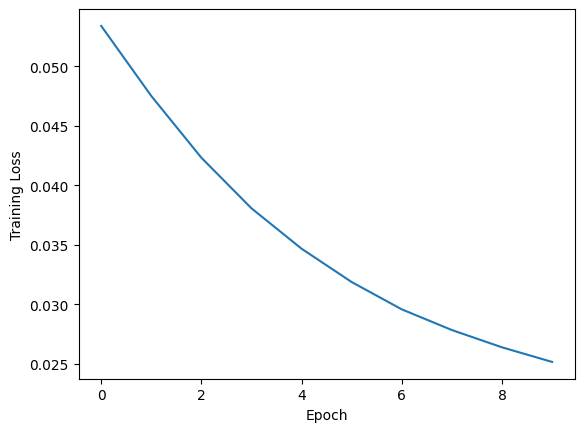

In [267]:
# Plot the loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

In [264]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a list to store the latent vectors
latent_vectors = []
labels = []

# Iterate over the sequences in the dataset and obtain their latent vectors
for sequence, label in zip(flatted_sequence, sequence_labels):
    # Transform the sequence tensor to have the shape (1, n_channels, sequence_length)
    sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
    sequence = sequence.float().to(device)

    # Obtain the latent vector
    latent_vector = model.encoder(sequence).detach().cpu().numpy()

    # Add the latent vector to the list
    latent_vectors.append(latent_vector)
    labels.append(label)


  
print(len(latent_vectors[0][0][0]))
print(len(latent_vectors[0][0]))
print(len(latent_vectors[0]))
print(len(latent_vectors))
#!pip install umap-learn
import umap.umap_ as umap

# Convert the list of latent vectors to a 2D numpy array
latent_vectors_array = np.array(latent_vectors)
print(latent_vectors_array.shape)
latent_vectors_array_reshaped = latent_vectors_array.reshape(len(latent_vectors), -1)
print(latent_vectors_array_reshaped.shape)

# Fit the UMAP model to the latent vectors
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
umap_embedding = umap_model.fit_transform(latent_vectors_array_reshaped)






375
8
1
2626
(2626, 1, 8, 375)
(2626, 3000)


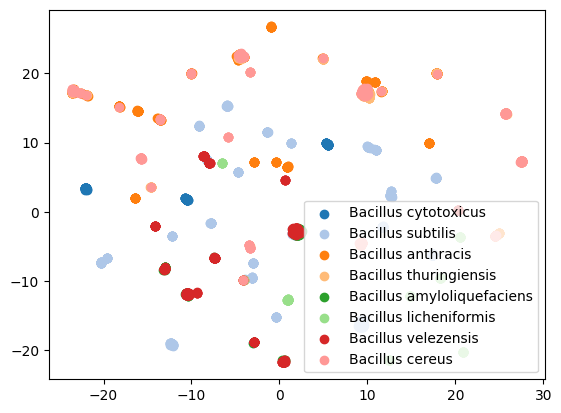

In [265]:
# Create a scatter plot for each unique label
unique_labels = set(labels)
color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

fig, ax = plt.subplots()
for label in unique_labels:
    # Get the indices of the data points with this label
    indices = [i for i, x in enumerate(labels) if x == label]
    
    # Get the corresponding UMAP coordinates and colors
    coords = umap_embedding[indices]
    color = color_dict[label]
    
    # Add the scatter plot for this label to the axes
    ax.scatter(coords[:, 0], coords[:, 1], color=color, label=label)

# Add a legend to the plot
ax.legend()

# Show the plot
plt.show()

In [ ]:
flatted_sequence[1]